https://github.com/hackthemarket/gym-trading/blob/master/gym_trading/envs/TradingEnv.ipynb

TODO:
- test data, val data
- multiple stocks?
- bitcoin data env?
    - quandl bter (200 results) bitfinex (26), BCHARTs
- finanical metrics e.g. 
    - http://www.cs.utexas.edu/~ai-lab/pubs/AMEC04-plat.pdf sharpes
    - return
    - dummy score
        - all buy, all hold, all sell
        - random etc
    - quantopians
- add more observational data
    - [x] the last few steps - add memmory
    - [ ] sentiment? e.g. https://www.quandl.com/data/NS1-FinSentS-Web-News-Sentiment
    - [ ] overall stock market e.g. https://www.quandl.com/data/UMICH/SOC4-University-of-Michigan-Consumer-Survey-Index-of-Consumer-Sentiment-Within-Regions
- replay https://github.com/matthiasplappert/keras-rl/issues/40
- or try openai baseline with tensorflow
- model
    - cnn
    - lstm
- unit tests
    - env should give poor result with random steps, only buys, only holds
    - model should overfit on small amount of data
    
- [x] pretraining? helps a lot. Lets the keras-rl beat the market by a few percent initially
 bugs:
 - [x] seems to be discontinuities causing huge navs e.g. 1e51
 
 
 regression vs classification
 
 window length and memory
 
 experience replay
 
 I used [arXiv:1612.01277](https://arxiv.org/abs/1706.10059) paper a lot for understanding the problem and ideas for model design.

In [1]:
# plotting
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

# numeric
import quandl
import numpy as np
from numpy import random
import pandas as pd

# utils
from tqdm import tqdm_notebook as tqdm
from collections import Counter
import pdb
import tempfile
import logging
import time

# logging
logger = log = logging.getLogger(__name__)
log.setLevel(logging.INFO)
logging.basicConfig()
log.info('%s logger started.', __name__)

INFO:__main__:__main__ logger started.


In [30]:
# reinforcement learning
import gym
from gym import error, spaces, utils
from gym.utils import seeding

from keras.models import Sequential
from keras.layers import Flatten, Dense, Activation, BatchNormalization
from keras.optimizers import Adam
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential
from keras.layers import Flatten, Dense, Activation, BatchNormalization, Conv1D, InputLayer, Dropout, regularizers, Conv2D, Reshape
from keras.optimizers import Adam
from keras.layers.advanced_activations import LeakyReLU
from keras.activations import relu

In [3]:
import os
os.sys.path.append(os.path.abspath('.'))
%reload_ext autoreload
%autoreload 2

# from src.callbacks.rl_callbacks import ReduceLROnPlateau, TrainIntervalLoggerTQDMNotebook

# Environment

Day trading over 256 days. We scale and augument the training data.

You can see the base environment class [here](https://github.com/openai/gym/blob/master/gym/core.py#L13) and openai's nice docs [here](https://gym.openai.com/docs)


In [4]:
from src.environments.portfolio import PortfolioEnv

In [5]:
df_train = pd.read_hdf('./data/poliniex_30m.hf',key='train')
env = PortfolioEnv(
    df=df_train,
    steps=128, 
    scale=True, 
    augument=0.0005    
)
env.seed = 0   

df_test = pd.read_hdf('./data/poliniex_30m.hf',key='test')
env_test = PortfolioEnv(
    df=df_test,
    steps=128, 
    scale=True, 
    augument=0.00)
env_test.seed = 0  

## SELU?

I tried SELU but it didn't help, It's mean to replace batchnorm and ELU with less parameters
there have been varied reports for it [reddit discussion]( https://www.reddit.com/r/MachineLearning/comments/6g5tg1/r_selfnormalizing_neural_networks_improved_elu/)

In [6]:
 
# from keras import backend as K
# def selu(x):
#     """Scaled Exponential Linear Unit. (Klambauer et al., 2017)
#     # Arguments
#         x: A tensor or variable to compute the activation function for.
#     # References
#         - [Self-Normalizing Neural Networks](https://arxiv.org/abs/1706.02515)
#     """
#     alpha = 1.6732632423543772848170429916717
#     scale = 1.0507009873554804934193349852946
#     return scale * K.elu(x, alpha)

# Model

arXiv:1612.01277 indicated that CNN's are just as effective. That's great because I like them, they are fast so I can try more things and see the results faster. So we will be using a CNN model.


In [29]:
env.reset().shape

(6, 8)

In [24]:
(window_length,)+env.observation_space.shape

(42, 6, 8)

# Pretrain the Q model as a normal classification problem

We can pretrain on a regular (non-rl) classification problem. This might not be as elegant as end-to-end training but it helps with speed. 

It also helps me quickly test how a model fit's the data (can it overfit, how much does it generalize?). So it's a good sanity check.

In [33]:
# augument the data to compensate for the low quantity
def random_shift(x, fraction):
    min_x, max_x = np.min(x), np.max(x)
    m = np.random.uniform(-fraction, fraction, size=x.shape) + 1
    c = np.random.uniform(-fraction, fraction, size=x.shape) * x.std()
    return np.clip(x * m + c, min_x, max_x)

def X_shift(X, fraction):
    X = X.copy()
    for i in range(X.shape[1]):
        x = X[:,:,i]
        X[:,:,i] = random_shift(x, fraction)
    return X

In [159]:
from keras.layers import Input, merge
from keras.layers import concatenate
from keras.models import Model
# Next, we build a very simple model.
actor = Sequential()
actor.add(InputLayer(input_shape=(window_length,) + env.observation_space.shape))
actor.add(Flatten())
actor.add(Dense(16))
actor.add(Activation('relu'))
actor.add(Dense(16))
actor.add(Activation('relu'))
actor.add(Dense(16))
actor.add(Activation('relu'))
actor.add(Dense(nb_actions))
actor.add(Activation('softmax'))
print(actor.summary())

action_input = Input(shape=(nb_actions,), name='action_input')
observation_input = Input(shape=(window_length,) + env.observation_space.shape, name='observation_input')
flattened_observation = Flatten()(observation_input)
x = concatenate([action_input, flattened_observation])
x = Dense(32)(x)
x = Activation('relu')(x)
x = Dense(32)(x)
x = Activation('relu')(x)
x = Dense(32)(x)
x = Activation('relu')(x)
x = Dense(1)(x)
x = Activation('linear')(x)
critic = Model(inputs=[action_input, observation_input], outputs=x)
print(critic.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 42, 6, 8)          0         
_________________________________________________________________
flatten_26 (Flatten)         (None, 2016)              0         
_________________________________________________________________
dense_95 (Dense)             (None, 16)                32272     
_________________________________________________________________
activation_89 (Activation)   (None, 16)                0         
_________________________________________________________________
dense_96 (Dense)             (None, 16)                272       
_________________________________________________________________
activation_90 (Activation)   (None, 16)                0         
_________________________________________________________________
dense_97 (Dense)             (None, 16)                272       
__________

In [160]:
from rl.agents.ddpg import DDPGAgent
from rl.policy import BoltzmannQPolicy, EpsGreedyQPolicy, LinearAnnealedPolicy
from rl.memory import SequentialMemory
from rl.random import OrnsteinUhlenbeckProcess

# Get the environment and extract the number of actions.
np.random.seed(0)

# Finally, we configure and compile our agent. You can use every built-in Keras optimizer and
# even the metrics!

memory = SequentialMemory(limit=1000, window_length=window_length)
random_process = OrnsteinUhlenbeckProcess(
    size=nb_actions, theta=.15, mu=0., sigma=.3)
agent = DDPGAgent(
    nb_actions=nb_actions,
    actor=actor,
    critic=critic,
    critic_action_input=action_input,
    random_process=random_process,
    memory=memory,
    
    nb_steps_warmup_critic=100,
    nb_steps_warmup_actor=100,    
    gamma=.99,
    target_model_update=1e-3
)
agent.compile(Adam(lr=1e-3), metrics=['mse'])
agent

In [161]:
from src.callbacks.keras_rl_callbacks import TrainIntervalLoggerTQDMNotebook

In [187]:
# Okay, now it's time to learn something! We visualize the training here for show, but this
# slows down training quite a lot. You can always safely abort the training prematurely using
# Ctrl + C.
history = agent.fit(env, 
                  nb_steps=900000, 
                  visualize=False, 
                  verbose=1,
                  callbacks=[
#                       TrainIntervalLoggerTQDMNotebook(),
#                       ReduceLROnPlateau(monitor='episode_reward', patience = 150)
                    ]
                 )

# After training is done, we save the final weights.
agent.save_weights('outputs/agent_{}_weights.h5f'.format('portfolio-ddpg-keras-rl'), overwrite=True)

Training for 900000 steps ...
Interval 1 (0 steps performed)
10000/10000 [==============================] - 246s - reward: -2.0639e-04   
78 episodes - episode_reward: -0.027 [-0.185, 0.110] - loss: 0.000 - mean_squared_error: 0.000 - mean_q: 0.000 - log_reward: 0.000 - portfolio_value: 1.000 - returns: 1.000 - rate_of_return: 0.000 - cost: 0.000 - steps: 0.000

Interval 2 (10000 steps performed)
10000/10000 [==============================] - 245s - reward: -2.2035e-04   
78 episodes - episode_reward: -0.028 [-0.255, 0.292] - loss: 0.000 - mean_squared_error: 0.000 - mean_q: -0.002 - log_reward: 0.000 - portfolio_value: 1.000 - returns: 0.999 - rate_of_return: 0.000 - cost: 0.000 - steps: 0.000

Interval 3 (20000 steps performed)
10000/10000 [==============================] - 241s - reward: 3.2417e-04   
78 episodes - episode_reward: 0.042 [-0.183, 5.335] - loss: 0.002 - mean_squared_error: 0.003 - mean_q: 0.000 - log_reward: 0.000 - portfolio_value: 1.000 - returns: 1.000 - rate_of_re

79 episodes - episode_reward: -0.014 [-0.143, 0.413] - loss: 0.000 - mean_squared_error: 0.000 - mean_q: 0.004 - log_reward: 0.000 - portfolio_value: 1.000 - returns: 1.001 - rate_of_return: 0.000 - cost: 0.000 - steps: 0.000

Interval 25 (240000 steps performed)
10000/10000 [==============================] - 248s - reward: -1.0241e-04   
78 episodes - episode_reward: -0.014 [-0.211, 0.295] - loss: 0.000 - mean_squared_error: 0.000 - mean_q: 0.003 - log_reward: 0.000 - portfolio_value: 1.000 - returns: 1.000 - rate_of_return: 0.000 - cost: 0.000 - steps: 0.000

Interval 26 (250000 steps performed)
10000/10000 [==============================] - 248s - reward: -1.4630e-04   
78 episodes - episode_reward: -0.018 [-0.115, 0.319] - loss: 0.000 - mean_squared_error: 0.000 - mean_q: 0.001 - log_reward: 0.000 - portfolio_value: 1.000 - returns: 1.000 - rate_of_return: 0.000 - cost: 0.000 - steps: 0.000

Interval 27 (260000 steps performed)
10000/10000 [==============================] - 248s - 

10000/10000 [==============================] - 249s - reward: -2.5934e-04   
79 episodes - episode_reward: -0.035 [-0.254, 0.161] - loss: 0.000 - mean_squared_error: 0.000 - mean_q: -0.001 - log_reward: 0.000 - portfolio_value: 1.000 - returns: 1.000 - rate_of_return: 0.000 - cost: 0.000 - steps: 0.000

Interval 49 (480000 steps performed)
10000/10000 [==============================] - 249s - reward: -1.3015e-04   
78 episodes - episode_reward: -0.017 [-0.223, 0.366] - loss: 0.000 - mean_squared_error: 0.000 - mean_q: -0.003 - log_reward: 0.000 - portfolio_value: 1.000 - returns: 1.000 - rate_of_return: 0.000 - cost: 0.000 - steps: 0.000

Interval 50 (490000 steps performed)
10000/10000 [==============================] - 250s - reward: 1.9390e-04   
78 episodes - episode_reward: 0.026 [-0.173, 0.927] - loss: 0.001 - mean_squared_error: 0.002 - mean_q: -0.001 - log_reward: 0.000 - portfolio_value: 1.000 - returns: 0.999 - rate_of_return: 0.000 - cost: 0.000 - steps: 0.000

Interval 51 (

10000/10000 [==============================] - 245s - reward: 2.2093e-04   
79 episodes - episode_reward: 0.027 [-0.164, 4.378] - loss: 0.001 - mean_squared_error: 0.002 - mean_q: 0.010 - log_reward: 0.000 - portfolio_value: 1.000 - returns: 1.001 - rate_of_return: 0.000 - cost: 0.000 - steps: 0.000

Interval 73 (720000 steps performed)
10000/10000 [==============================] - 245s - reward: -1.7273e-04   
78 episodes - episode_reward: -0.022 [-0.174, 0.174] - loss: 0.000 - mean_squared_error: 0.000 - mean_q: 0.009 - log_reward: 0.000 - portfolio_value: 1.000 - returns: 1.000 - rate_of_return: 0.000 - cost: 0.000 - steps: 0.000

Interval 74 (730000 steps performed)
10000/10000 [==============================] - 247s - reward: -1.4076e-04   
78 episodes - episode_reward: -0.018 [-0.178, 0.343] - loss: 0.000 - mean_squared_error: 0.000 - mean_q: 0.006 - log_reward: 0.000 - portfolio_value: 1.000 - returns: 0.999 - rate_of_return: 0.000 - cost: 0.000 - steps: 0.000

Interval 75 (740

In [188]:
agent.save_weights('outputs/agent_{}_weights.h5f'.format('portfolio-ddpg-keras-rl'), overwrite=True)

In [189]:
# Finally, evaluate our algorithm for 5 episodes.
agent.test(env_test, nb_episodes=10, visualize=False)

Testing for 10 episodes ...
Episode 1: reward: 0.024, steps: 128
Episode 2: reward: -0.000, steps: 128
Episode 3: reward: -0.024, steps: 128
Episode 4: reward: -0.311, steps: 128
Episode 5: reward: 0.020, steps: 128
Episode 6: reward: 0.093, steps: 128
Episode 7: reward: -0.097, steps: 128
Episode 8: reward: -0.033, steps: 128
Episode 9: reward: -0.113, steps: 128
Episode 10: reward: -0.065, steps: 128


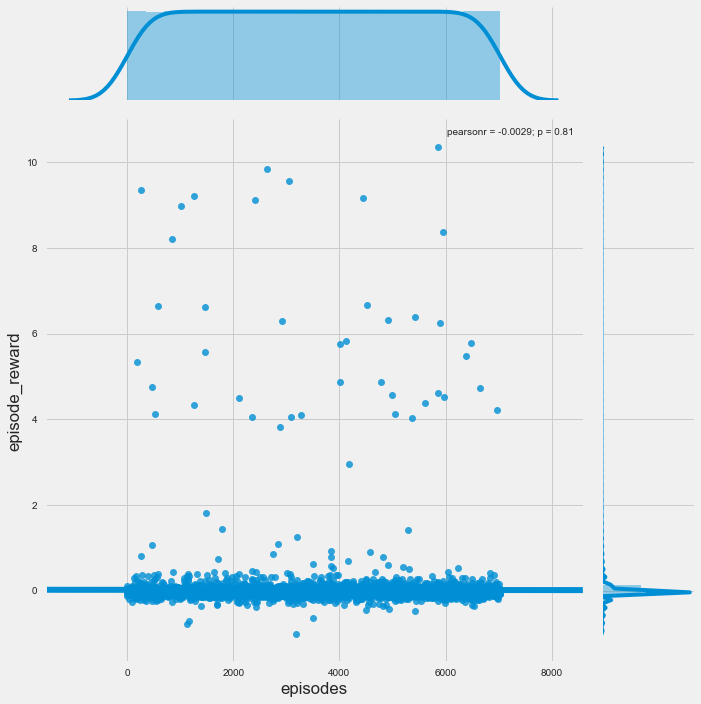

In [190]:
# history
df_hist = pd.DataFrame(history.history)
df_hist
df_hist['episodes'] = df_hist.index

g = sns.jointplot(x="episodes", y="episode_reward", data=df_hist, kind="reg", size=10)
plt.show()


# g = sns.jointplot(x="episodes", y="rewards", data=history, kind="reg")

# visualise

ideally a price with colored actions? like https://hackernoon.com/the-self-learning-quant-d3329fcc9915

# dummy metrics

In [ ]:
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.model_selection import train_test_split


X_flat = X_train.reshape((len(X_train),-1))
X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(X_flat, y_train, test_size=0.2, random_state=0)

def test_env(env, model, memory):
    obs = env.reset()
    state = memory.get_recent_state(obs)
    for t in range(env.days):
        x_batch = np.array([state])
        x_flat = x_batch.reshape((len(x_batch),-1))
        x_flat[np.isnan(x_flat)]=0
        y_pred = model.predict(x_flat)
        action = y_pred.argmax(1)
        obs, rew, done, info = env.step(action[0])
        state = memory.get_recent_state(obs)
    
    df_test = env.sim.to_df()
    end = df_test.iloc[-1]
    gain = end.bod_nav - end.mkt_nav    
    return gain

dummy_scores = []
for strategy in ['most_frequent', 'uniform', 'prior', 'stratified']:
    memory = Memory(window_length=window_length)
    clf = DummyClassifier(strategy=strategy)
    clf.fit(X_train, y_train)
    gain = test_env(env_test, clf, memory)
    df=env_test.sim.to_df()
    print('{:20.20s}: {: 3.2%} /day NAV gain above market'.format(strategy, (df.mkt_nav-df.bod_nav).mean()))
    
    plot_env(env_test, title=strategy)  

for strategy in ['mean', 'median']:
    memory = Memory(window_length=window_length)
    clf=DummyRegressor(strategy=strategy)
    clf.fit(X_train, y_train)
    gain = test_env(env_test, clf, memory)
    df=env_test.sim.to_df()
    print('{:20.20s}: {: 3.2%} /day NAV gain above market'.format(strategy, (df.mkt_nav-df.bod_nav).mean()))
    
    plot_env(env_test, title=strategy)  

In [ ]:
plot_env(env_test)